<a href="https://colab.research.google.com/github/mohsenfaghih13/AOD/blob/main/05_pinn_hybrid_icrealdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving AOD_lat_lon_t.csv to AOD_lat_lon_t.csv


In [ ]:
import pandas as pd

df = pd.read_csv("AOD_lat_lon_t.csv")

df.head()


,lon,lat,AOD,t
0,-160.63,51.08,0.186651,0.677247
1,-160.59,51.08,0.165999,0.677247
2,-160.56,51.08,0.141802,0.677247
3,-160.52,51.08,0.176248,0.677247
4,-160.49,51.07,0.184185,0.677247


Epoch 0, Total Loss: 0.151848 | PDE: 8.63e-03 | IC: 1.40e-01 | BC: 3.46e-03
Epoch 200, Total Loss: 0.127292 | PDE: 2.49e-04 | IC: 1.18e-01 | BC: 9.31e-03
Epoch 400, Total Loss: 0.122370 | PDE: 5.12e-04 | IC: 1.14e-01 | BC: 7.51e-03
Epoch 600, Total Loss: 0.120669 | PDE: 3.36e-04 | IC: 1.14e-01 | BC: 5.94e-03
Epoch 800, Total Loss: 0.120011 | PDE: 4.95e-04 | IC: 1.13e-01 | BC: 6.61e-03
Epoch 1000, Total Loss: 0.119759 | PDE: 5.30e-04 | IC: 1.13e-01 | BC: 6.52e-03
Epoch 1200, Total Loss: 0.119566 | PDE: 5.55e-04 | IC: 1.13e-01 | BC: 6.42e-03
Epoch 1400, Total Loss: 0.119416 | PDE: 5.62e-04 | IC: 1.13e-01 | BC: 6.25e-03
Epoch 1600, Total Loss: 0.119225 | PDE: 5.85e-04 | IC: 1.12e-01 | BC: 6.36e-03
Epoch 1800, Total Loss: 0.118929 | PDE: 5.73e-04 | IC: 1.12e-01 | BC: 6.35e-03


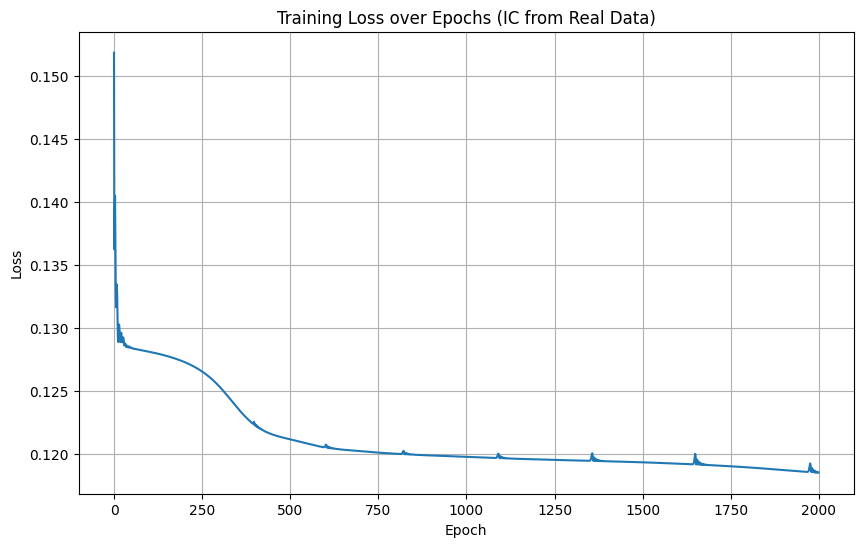

In [ ]:
# -------------------------------
# 1. Imports
# -------------------------------
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# -------------------------------
# 2. Define PINN model
# -------------------------------
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, xyt):
        return self.net(xyt)

# -------------------------------
# 3. Derivatives using autograd
# -------------------------------
def derivatives(u, xyt):
    grad_u = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]
    u_t = grad_u[:, 2:3]

    u_xx = autograd.grad(u_x, xyt, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, xyt, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]

    return u_t, u_x, u_y, u_xx, u_yy

# -------------------------------
# 4. PDE Residual
# -------------------------------
def pde_residual(model, xyt, vx=1.0, vy=0.5, D=0.01):
    u = model(xyt)
    u_t, u_x, u_y, u_xx, u_yy = derivatives(u, xyt)
    return u_t + vx * u_x + vy * u_y - D * (u_xx + u_yy)

# -------------------------------
# 5. Generate Collocation and Boundary Points (Synthetic)
# -------------------------------
def gen_data(Nf=1000, Nbc=200):
    def rand_xy(N):
        x = torch.rand(N, 1)
        y = torch.rand(N, 1)
        return x, y

    def rand_t(N):
        return torch.rand(N, 1)

    # Interior points
    xf, yf = rand_xy(Nf)
    tf = rand_t(Nf)
    xyt_f = torch.cat([xf, yf, tf], dim=1).requires_grad_()

    # Boundary points
    tb = rand_t(Nbc)
    y_b1 = torch.rand(Nbc, 1)
    bc1 = torch.cat([torch.zeros(Nbc, 1), y_b1, tb], dim=1)
    bc2 = torch.cat([torch.ones(Nbc, 1), y_b1, tb], dim=1)
    x_b2 = torch.rand(Nbc, 1)
    bc3 = torch.cat([x_b2, torch.zeros(Nbc, 1), tb], dim=1)
    bc4 = torch.cat([x_b2, torch.ones(Nbc, 1), tb], dim=1)
    xyt_bc = torch.cat([bc1, bc2, bc3, bc4], dim=0).requires_grad_()

    return xyt_f, xyt_bc

# -------------------------------
# 6. Load your real data
# -------------------------------
df = pd.read_csv("AOD_lat_lon_t.csv")

# Normalize lat/lon
scaler = MinMaxScaler()
df[['lon_norm', 'lat_norm']] = scaler.fit_transform(df[['lon', 'lat']])

# Prepare torch tensors for IC (initial condition)
t_val = df['t'].iloc[0]
t_tensor = torch.full((len(df), 1), fill_value=t_val, dtype=torch.float32)

x_tensor = torch.tensor(df[['lon_norm']].values, dtype=torch.float32)
y_tensor = torch.tensor(df[['lat_norm']].values, dtype=torch.float32)

xyt_ic = torch.cat([x_tensor, y_tensor, t_tensor], dim=1).requires_grad_()
u_ic = torch.tensor(df[['AOD']].values, dtype=torch.float32)


# -------------------------------
# 7. Prepare other points
# -------------------------------
xyt_f, xyt_bc = gen_data(Nf=1000, Nbc=200)

# -------------------------------
# 8. Train the model
# -------------------------------
model = PINN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_log = []

for epoch in range(2000):
    opt.zero_grad()

    # PDE residual loss
    f = pde_residual(model, xyt_f)
    loss_pde = (f**2).mean()

    # Initial condition loss (from your real data)
    u_pred_ic = model(xyt_ic)
    loss_ic = ((u_pred_ic - u_ic)**2).mean()

    # Boundary condition loss
    u_pred_bc = model(xyt_bc)
    loss_bc = (u_pred_bc**2).mean()

    # Total loss (no data loss, only IC + PDE + BC)
    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    opt.step()

    loss_log.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f} | PDE: {loss_pde.item():.2e} | IC: {loss_ic.item():.2e} | BC: {loss_bc.item():.2e}")

# -------------------------------
# 9. Plot the loss
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(loss_log)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs (IC from Real Data)")
plt.grid(True)
plt.show()
